In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min





# Assuming you have your gene expression data in 'X_train' (with cells as rows, genes as columns)







In [89]:
import sys
import os
os.chdir('C:/Users/jccarado/Downloads/rotation_3')
X_train = pd.read_csv('e17_expr.csv', index_col=0)
cell_labels = pd.read_csv('e17_labels.csv', index_col=0, header=None)
print(X_train)

         E17_5_AAACCTGAGCCAGAAC-1  E17_5_AAACCTGAGGCAATTA-1  \
Sox17                           0                         0   
Mrpl15                          0                         0   
Lypla1                          0                         0   
Tcea1                           0                         0   
Rgs20                           1                         0   
...                           ...                       ...   
Cldn16                          0                         0   
Stfa1                           0                         0   
Gm20683                         0                         0   
Ankrd1                          0                         0   
Sfrp5                           0                         0   

         E17_5_AAACCTGAGTGTCTCA-1  E17_5_AAACCTGCACATCCAA-1  \
Sox17                           0                         0   
Mrpl15                          1                         0   
Lypla1                          0                     

In [159]:
def mse_loss(reconstructed, original):
    # Cast both tensors to float32 to avoid type mismatch
    reconstructed = tf.cast(reconstructed, tf.float32)
    original = tf.cast(original, tf.float32)
    return tf.reduce_mean(tf.square(reconstructed - original))


def kl_divergence(p, q):
    # Add a small epsilon to avoid log(0) issues
    epsilon = 1e-10
    p = tf.clip_by_value(p, epsilon, 1.0)
    q = tf.clip_by_value(q, epsilon, 1.0)
    return tf.reduce_sum(p * (tf.math.log(p) - tf.math.log(q)), axis=-1)

def combined_loss(reconstructed, original, p_cluster, q_cluster, alpha=1.0, beta=1.0):
    # Compute MSE loss
    mse = mse_loss(reconstructed, original)
    
    # Compute KL Divergence loss
    kl_loss = kl_divergence(p_cluster, q_cluster)
    mse = tf.cast(mse, tf.float32)
    kl_loss = tf.cast(kl_loss, tf.float32)
    # Total loss is a weighted sum of MSE and KL divergence
    return alpha * mse + beta * kl_loss

In [174]:

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model

def create_stacked_autoencoder(input_shape, num_clusters):
    # Encoder
    input_data = layers.Input(shape=input_shape, name='input_layer')  # Input layer
    
    # Encoder layers (stacked)
    x = layers.Dense(256, activation='relu')(input_data)  # First encoding layer        # Second encoding layer
    latent_space = layers.Dense(128, activation='tanh')(x)  # Bottleneck layer (latent representation)
    
    x = layers.Dense(256, activation='relu')(x)            # Second decoding layer
    reconstruction = layers.Dense(input_shape, activation='relu', name='reconstruction')(x)  # Output reconstruction
    
    # Clustering output (softmax for probabilities)
    cluster_probs = layers.Dense(num_clusters, activation='softmax', name='clusters')(latent_space)  # Softmax output
    
    # Define the full model (encoder + decoder)
    model = models.Model(inputs=input_data, outputs=[reconstruction, cluster_probs])
    
    return model

In [ ]:


class KLLossCallBack(tf.keras.callbacks.Callback):
    def __init__(self, X_train, cell_labels_numeric, encoder):
        super(KLLossCallBack, self).__init__()
        self.X_train = X_train
        self.cell_labels_numeric = cell_labels_numeric
        self.encoder = encoder
        self.kl_values = []
        self.p_dist = []
        self.q_dist = []
        self.cluster_labels = []
        self.num_classes = len(np.unique(self.cell_labels_numeric))
        self.num_classes_q = len(np.unique(self.cluster_labels))

    def on_epoch_end(self, epoch, logs=None):
        # Get the encoded data after this epoch
        encoded_data = self.encoder.predict(self.X_train)[0]
        adata = anndata.AnnData(encoded_data)
        sc.pp.pca(adata)
        sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
        sc.tl.louvain(adata)  # Run Louvain clustering on the encoded data
        
        self.cluster_labels = adata.obs['louvain']  # Extract cluster labels
        self.num_classes_q = len(np.unique(self.cluster_labels))
        # Compute KL Divergence Loss
        self.p_dist = tf.one_hot(self.cluster_labels, depth=14, dtype=tf.float32)
        self.q_dist = tf.one_hot(self.cell_labels_numeric, depth=14, dtype=tf.float32)
        kl_score = kl_divergence(self.p_dist, self.q_dist)
        kl_score = tf.reduce_mean(kl_score)
        self.kl_values.append(kl_score)
        # Optionally print KL at every epoch
        print(kl_score)

    def plot_kl(self):
        # Plot ARI across epochs
        plt.plot(range(1, len(self.kl_values) + 1), self.kl_values)
        plt.xlabel('Epochs')
        plt.ylabel('KL Loss')
        plt.title('KL Loss through Epochs')
        plt.show()
    

In [180]:
from sklearn.mixture import GaussianMixture
from keras.callbacks import EarlyStopping
import scanpy as sc
import desc

scaler = StandardScaler()
#X_train = X_train.T
input_dim = X_train.shape[1]

# Build the autoencoder model as before

# Use K-means to initialize the cluster labels


encoder = create_stacked_autoencoder(input_dim, 14)
adata = sc.AnnData(X_train)
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.louvain(adata) 

# Train the model with the combined loss
#autoencoder.compile(optimizer='adam', loss=lambda y_true, y_pred: clustering_loss(y_true, y_pred, encoded_data, cluster_labels, 14))
cluster_labels = adata.obs['louvain'].astype(int)

cell_type_counts = cell_labels.value_counts()
sorted_cell_types = cell_type_counts.sort_values(ascending=False)
print("GT: ", sorted_cell_types)
# Ensure cluster_labels is a Pandas Series
sorted_cluster_labels = pd.Series(cluster_labels).value_counts().sort_values(ascending=False)
print("Prediction", sorted_cluster_labels)
cell_type_to_numeric = {cell_type: idx for idx, cell_type in enumerate(sorted_cell_types.index)}

cell_type_to_numeric = {key[0]: value for key, value in cell_type_to_numeric.items()}


GT:  1                       
UL CPN                      963
Migrating neurons           852
Interneurons                783
DL CPN                      486
Layer 4                     412
CThPN                       392
Astrocytes                  294
SCPN                        164
Cycling glial cells         147
Intermediate progenitors    130
Oligodendrocytes             33
Cajal Retzius cells          17
Endothelial cells             9
Microglia                     8
Name: count, dtype: int64
Prediction louvain
0     902
1     686
2     568
3     487
4     450
5     340
6     294
7     286
8     247
9     139
10    123
11     83
12     48
13     37
Name: count, dtype: int64


In [101]:
print(encoder.summary())

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 15127)]      0           []                               
                                                                                                  
 dense_31 (Dense)               (None, 256)          3872768     ['input_layer[0][0]']            
                                                                                                  
 dense_33 (Dense)               (None, 256)          65792       ['dense_31[0][0]']               
                                                                                                  
 dense_32 (Dense)               (None, 128)          32896       ['dense_31[0][0]']               
                                                                                           

In [170]:

def getdims(x=(10000,200)):
    """
    return the dims for network
    """
    assert len(x)==2
    n_sample=x[0]
    if n_sample>20000:# may be need complex network
        dims=[x[-1],128,32]
    elif n_sample>10000:#10000
        dims=[x[-1],64,32]
    elif n_sample>5000: #5000
        dims=[x[-1],32,16] #16
    elif n_sample>2000:
        dims=[x[-1],128]
    elif n_sample>500:
        dims=[x[-1],64]
    else:
        dims=[x[-1],16]
    #dims=[x[-1],64,32] if n_sample>10000 else [x[-1],32,16]
    return dims
dims= getdims(adata.shape)
print(dims)
print(adata.shape)

[15127, 128]
(4690, 15127)


In [171]:

cell_labels_numeric = cell_labels.iloc[:,0].map(cell_type_to_numeric)
sorted_cell_types = cell_labels_numeric.value_counts().sort_values(ascending=False)
print(cell_labels_numeric)

0
E17_5_AAACCTGAGCCAGAAC-1    6
E17_5_AAACCTGAGGCAATTA-1    3
E17_5_AAACCTGAGTGTCTCA-1    5
E17_5_AAACCTGCACATCCAA-1    2
E17_5_AAACCTGCACGAAATA-1    4
                           ..
E17_5_TTTGTCAGTCAGAAGC-1    3
E17_5_TTTGTCAGTCCAGTTA-1    9
E17_5_TTTGTCAGTTGTACAC-1    5
E17_5_TTTGTCATCACAACGT-1    2
E17_5_TTTGTCATCGGCGCTA-1    3
Name: 1, Length: 4690, dtype: int64


In [181]:
import keras
import tensorflow as tf
from sklearn.metrics import adjusted_rand_score
from keras import layers, models
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
%matplotlib inline


cluster_labels_tf = tf.convert_to_tensor(cluster_labels)
p_cluster = tf.one_hot(cluster_labels, depth=14, dtype=tf.float32)
q_cluster = tf.one_hot(cell_labels_numeric, depth=14, dtype=tf.float32)
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
kl_callback = KLLossCallBack(X_train, cell_labels_numeric, encoder=encoder)
encoder.compile(optimizer=SGD(0.001, momentum=0.9), loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, p_cluster, q_cluster, alpha=1.0, beta=1.0))
#encoder.compile(optimizer=SGD(0.01, momentum=0.9), loss='mse')



Epoch 1/100
147/147 [==============================] - 1s 6ms/steposs: 42.2029 - reconstruction_loss: 
tf.Tensor([23.025852 23.025852 23.025852 ... 23.025852 23.025852 23.025852], shape=(4690,), dtype=float32)
147/147 [==============================] - 9s 57ms/step - loss: 42.2029 - reconstruction_loss: 21.2413 - clusters_loss: 20.9616
Epoch 2/100
147/147 [==============================] - 1s 6ms/steposs: 42.1939 - reconstruction_loss
tf.Tensor([23.025852 23.025852 23.025852 ... 23.025852 23.025852 23.025852], shape=(4690,), dtype=float32)
147/147 [==============================] - 9s 59ms/step - loss: 42.1938 - reconstruction_loss: 21.2378 - clusters_loss: 20.9560
Epoch 3/100
147/147 [==============================] - 1s 6ms/steposs: 42.1841 - reconstruction_lo
tf.Tensor([23.025852 23.025852 23.025852 ... 23.025852 23.025852 23.025852], shape=(4690,), dtype=float32)
147/147 [==============================] - 8s 55ms/step - loss: 42.1840 - reconstruction_loss: 21.2325 - clusters_loss: 

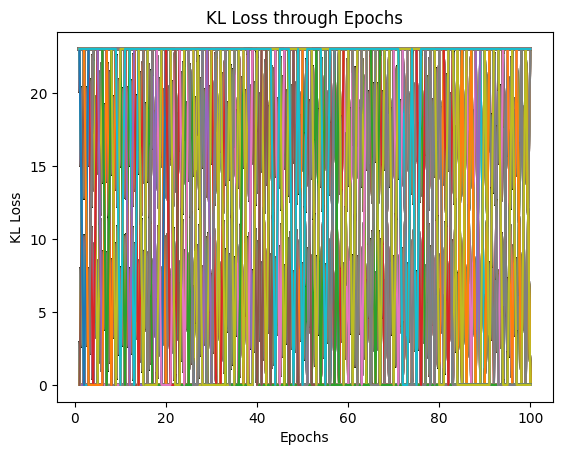

In [182]:
encoder.fit(X_train, [X_train, p_cluster], batch_size=32, epochs=100, callbacks=[kl_callback, early_stopping])
kl_callback.plot_kl()

In [184]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
n_clusters = np.unique(cell_labels_numeric).shape[0]
km = KMeans(n_clusters, n_init=20)
y_pred = km.fit_predict(encoder.predict(X_train)[0])
y = cell_labels_numeric
print(tf.keras.losses.KLDivergence()(kl_callback.p_dist, kl_callback.q_dist))
print ('K-means clustering result on extracted features: NMI =', normalized_mutual_info_score(y, y_pred))

147/147 [==============================] - 1s 9ms/step
tf.Tensor(12.7020035, shape=(), dtype=float32)
K-means clustering result on extracted features: NMI = 0.49852298283192564


In [151]:

print(tf.keras.losses.KLDivergence()(kl_callback.p_dist, kl_callback.q_dist))

tf.Tensor(14.626551, shape=(), dtype=float32)


Number of clusters adjusted to match the ground truth cell types (14).


In [111]:
print(kmeans)

KMeans(n_clusters=14, random_state=42)


GT:  1                       
UL CPN                      963
Migrating neurons           852
Interneurons                783
DL CPN                      486
Layer 4                     412
CThPN                       392
Astrocytes                  294
SCPN                        164
Cycling glial cells         147
Intermediate progenitors    130
Oligodendrocytes             33
Cajal Retzius cells          17
Endothelial cells             9
Microglia                     8
Name: count, dtype: int64
Prediction 7     1576
1     1150
13     648
10     200
3      134
2      130
11     130
8      114
0      109
4      106
12     105
5      102
9       95
6       91
Name: count, dtype: int64
{'UL CPN': 0, 'Migrating neurons': 1, 'Interneurons': 2, 'DL CPN': 3, 'Layer 4': 4, 'CThPN': 5, 'Astrocytes': 6, 'SCPN': 7, 'Cycling glial cells': 8, 'Intermediate progenitors': 9, 'Oligodendrocytes': 10, 'Cajal Retzius cells': 11, 'Endothelial cells': 12, 'Microglia': 13}


In [183]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score
nmi_score = normalized_mutual_info_score(kl_callback.cell_labels_numeric, kl_callback.cluster_labels)
ami_score = adjusted_mutual_info_score(kl_callback.cell_labels_numeric, kl_callback.cluster_labels)
print(f"Normalized Mutual Info: {nmi_score}")
print(f"Adjusted Mutual Information: {ami_score}")

Normalized Mutual Info: 0.6436230995933904
Adjusted Mutual Information: 0.6414786286842789


c:\Users\jccarado\keras-retinanet\myenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[0 1 2 3 4 5 6 7 8 9]


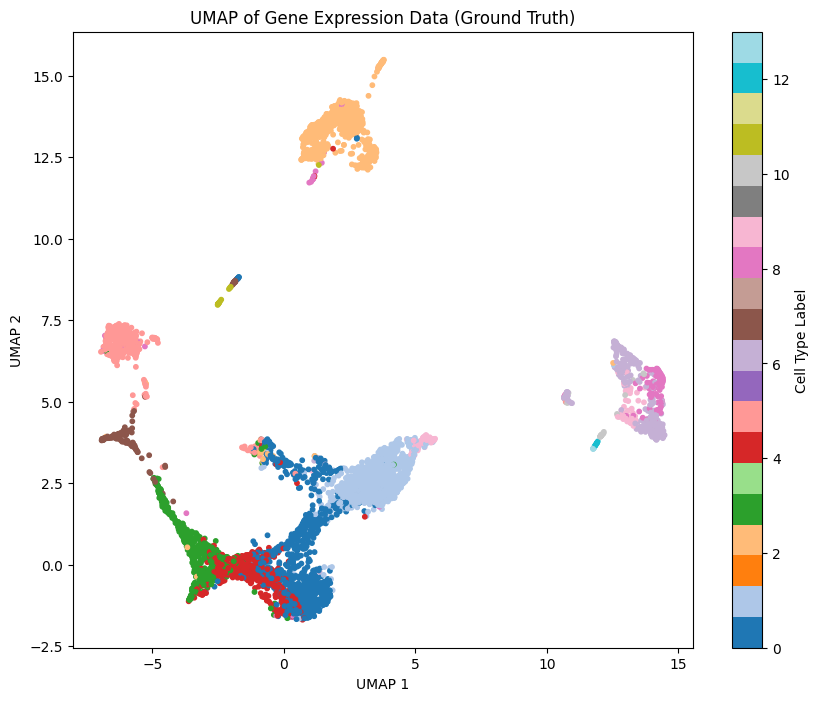

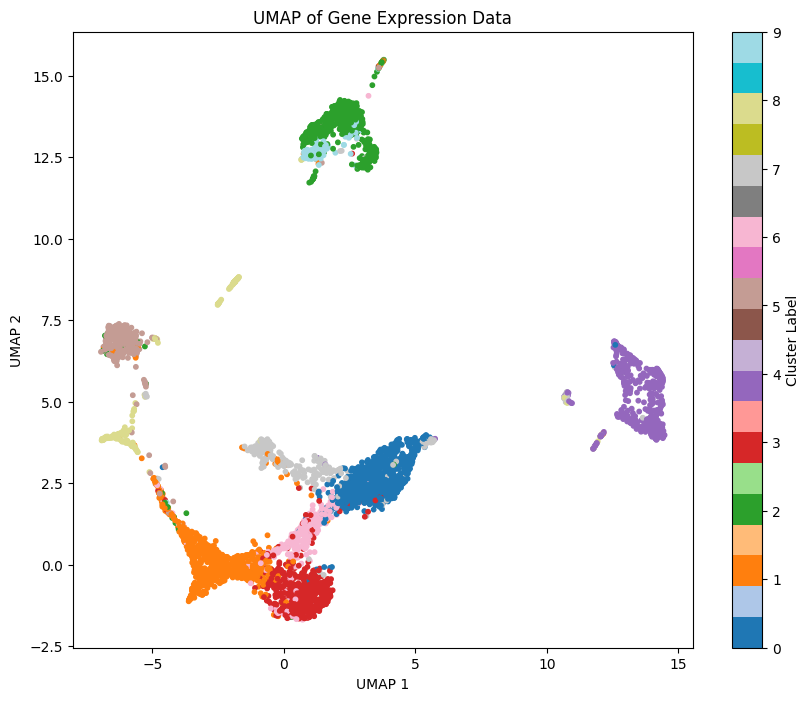

In [185]:
import umap
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
%matplotlib inline


pca = PCA(n_components=50)  # You can change this value as needed
X_pca = pca.fit_transform(X_train)

umap_model = umap.UMAP(n_components=2)  # We want to reduce it to 2D for visualization
X_umap = umap_model.fit_transform(X_pca)
cluster_labels = kl_callback.cluster_labels
cluster_labels = cluster_labels.astype('category').cat.codes
print(np.unique(cluster_labels))
# Step 4: Visualize the UMAP projection
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cell_labels_numeric, cmap='tab20', s=10)
plt.title('UMAP of Gene Expression Data (Ground Truth)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Cell Type Label')
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c= cluster_labels, cmap='tab20', s=10)
plt.title('UMAP of Gene Expression Data')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Cluster Label')
plt.show()

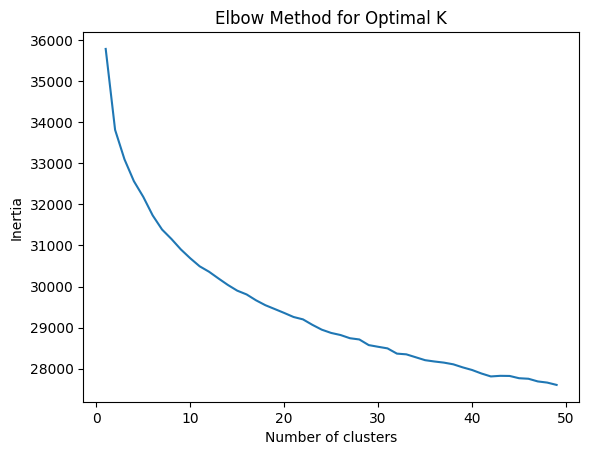

In [308]:

inertias = []
for n in range(1, 50):  # Try values from 1 to 20
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(encoded_data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 50), inertias)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


ValueError: too many values to unpack (expected 2)

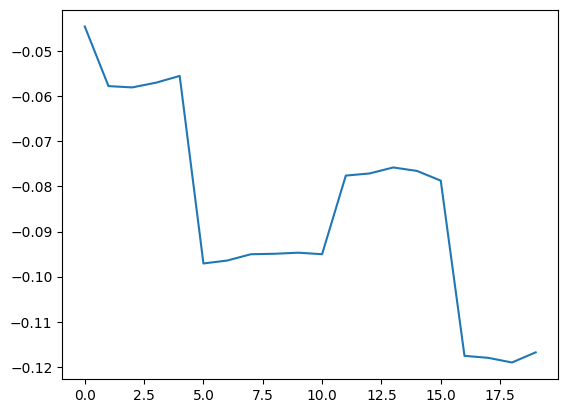

In [ ]:
silhouette_scores = []
for n in np.arange(0.1, 2.1, 0.1):  # test only from 5 to 15
    sc.tl.louvain(adata, resolution=n) 
    cluster_labels = adata.obs['louvain'].astype(int) 
    silhouette_scores.append(silhouette_score(X_train, cluster_labels))





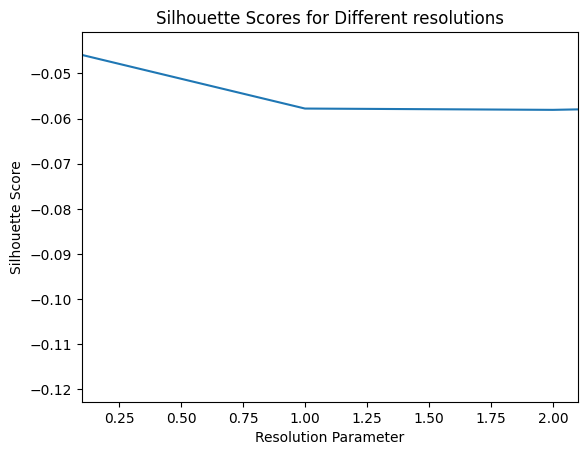

[-0.04456045265157051, -0.05777467469548003, -0.05806381567943037, -0.0570164629356897, -0.05551755056752821, -0.09707730323234497, -0.09643096550254393, -0.09503462227944978, -0.09492910520259457, -0.09469052950506848, -0.09502970820757418, -0.0776027810423989, -0.07713369133098834, -0.07580180732171923, -0.07657636372760518, -0.07872461508179715, -0.11755055445857801, -0.11799246426116707, -0.11902102856264991, -0.1167767521569091]


In [321]:
plt.plot(silhouette_scores)
plt.xlim(0.1,2.1)
plt.xlabel('Resolution Parameter')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different resolutions')
plt.show()

print(silhouette_scores)